In [1]:
import os
os.chdir("C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\Code")
import sys
from Get_file import Get_file   # return dirpath, dirnames, filenames
from FFT import FFT
import pyedflib
import numpy as np
from scipy.signal import butter, lfilter
from scipy.signal import freqz
import matplotlib.pyplot as plt

# Setting parameters
Sample_frequency = 128
DEBUG = True
label_size = 40
channel_we_use = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]   # 0~39 共40


In [2]:
#Four Lables
normal_lable = []   # 0
scare_lable = []    # 1
touch_lable = []    # 2
laugh_lable = []    # 3

#Four Signal
normal_signal = []
scare_signal = []
touch_signal = []
laugh_signal = []

signal = []
labels = []

data_path = "C:\\Users\\zxpay\\Desktop\\BME_Senior\\EEG_CLF\\Emotion\\database"

_,data_files,_ = Get_file(data_path)
if data_files == []:
    raise("Not found any files ! check your data_path")
else:
    print('Get data from database ...')
    for data in data_files:
        _,_,file_names = Get_file(data_path+'\\'+data)
        for fn in file_names:
            if fn.split('.')[1] == 'edf':
                if DEBUG:
                    #print(data_path+'\\'+data+'\\'+fn)
                    pass
                fedf = pyedflib.EdfReader(data_path+'\\'+data+'\\'+fn)
                n = fedf.signals_in_file
                signal_labels = np.asarray(fedf.getSignalLabels())
                sigbufs = np.zeros((n, fedf.getNSamples()[0]))
                for i in np.arange(n):
                    sigbufs[i, :] = fedf.readSignal(i)

                if 'normal' in fn:
                    normal_lable.append(0)
                    normal_signal.append(sigbufs)
                elif 'scare' in fn:
                    scare_lable.append(1)
                    scare_signal.append(sigbufs)
                elif 'touch' in fn:
                    touch_lable.append(2)
                    touch_signal.append(sigbufs)
                elif 'laugh' in fn:
                    laugh_lable.append(3)
                    laugh_signal.append(sigbufs)
                    
                if DEBUG:
                    print(sigbufs.shape)

''' Labels --> 40 channels
['COUNTER' 'INTERPOLATED' 'AF3' 'F7' 'F3' 'FC5' 'T7' 'P7' 'O1' 'O2' 'P8'
 'T8' 'FC6' 'F4' 'F8' 'AF4' 'RAW_CQ' 'GYROX' 'GYROY' 'MARKER'
 'MARKER_HARDWARE' 'SYNC' 'TIME_STAMP_s' 'TIME_STAMP_ms' 'CQ_AF3' 'CQ_F7'
 'CQ_F3' 'CQ_FC5' 'CQ_T7' 'CQ_P7' 'CQ_O1' 'CQ_O2' 'CQ_P8' 'CQ_T8' 'CQ_FC6'
 'CQ_F4' 'CQ_F8' 'CQ_AF4' 'CQ_CMS' 'CQ_DRL']
'''

print('Okay')
if DEBUG:
    print('normal signal length : ', len(normal_signal))
    print('scare signal length : ', len(scare_signal))
    print('touch signal length : ', len(touch_signal))
    print('laugh signal length : ', len(laugh_signal))



Get data from database ...
(40, 38400)
(40, 105344)
(40, 38400)
(40, 105344)
(40, 179328)
(40, 309760)
(40, 38400)
(40, 105728)
(40, 158976)
(40, 58112)
(40, 50944)
(40, 33152)
(40, 3968)
(40, 38400)
(40, 105344)
(40, 178944)
(40, 308992)
(40, 38400)
(40, 105728)
(40, 179840)
(40, 38400)
(40, 178944)
(40, 308864)
(40, 38400)
(40, 105344)
(40, 179072)
(40, 83328)
(40, 117632)
(40, 107392)
(40, 38400)
(40, 308992)
(40, 38400)
(40, 179072)
(40, 105344)
(40, 308736)
(40, 38400)
(40, 313472)
(40, 38400)
(40, 105344)
(40, 38400)
(40, 105344)
(40, 38528)
(40, 179200)
(40, 308736)
(40, 38400)
(40, 179328)
(40, 38400)
(40, 105344)
Okay
normal signal length :  15
scare signal length :  10
touch signal length :  8
laugh signal length :  15


In [3]:
# Band pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Lowpass filter
def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = True)
    return b, a

def butter_lowpass_filter(data, cutOff, fs, order=4):
    b, a = butter_lowpass(cutOff, fs, order=order)
    y = lfilter(b, a, data)
    return y

(64,)
(64,)


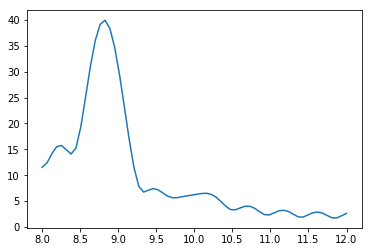

In [4]:
# Split the data from each channel
def Get_signal(raw_data, channel, sample_freq=128):
    times = int(raw_data.shape[1]/Sample_frequency)
    datai = []
    signal_alpha = []
    signal_beta = []
    num_sp = 0
    for i in range(times):
        datai.append(raw_data[channel][num_sp:(num_sp+sample_freq)])
        num_sp += sample_freq

    for x in datai:
        alpha = butter_bandpass_filter(x,8,12,Sample_frequency)
        alpha = alpha[8:13]
        beta = butter_bandpass_filter(x,13,30,Sample_frequency)
        beta = beta[13:31]
        freq_alpha, data_alpha = FFT(alpha, Sample_frequency, Sample_frequency)
        freq_bata, data_beta = FFT(beta, Sample_frequency, Sample_frequency)
        signal_alpha.append(data_alpha)
        signal_beta.append(data_beta)
        
    alpha_mean = np.asarray(signal_alpha)
    alpha_mean = np.mean(alpha_mean, 0)
    beta_mean = np.asarray(signal_beta)
    beta_mean = np.mean(beta_mean, 0)
    return alpha_mean, beta_mean
# example
x = np.linspace(0,1,64)
a, b = Get_signal(scare_signal[4], 14, 128)   # each data samples is 64
if DEBUG:
    print(a.shape)
    print(b.shape)
X = np.linspace(8,12,a.shape[0])
plt.plot(X,b)
plt.show()

In [5]:
# Get all normal signal data
# Data shape : 64 X 14 X person_numbers       ， 14 is 14 channels
normal_alpha = np.zeros([64,14,len(normal_signal)], dtype=np.float32)
normal_beta = np.zeros([64,14,len(normal_signal)], dtype=np.float32)
ch_num = 0
for i in range(len(normal_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            delta_a, delta_b = Get_signal(normal_signal[i], ch, Sample_frequency)
            normal_alpha[:,ch_num,i] = delta_a
            normal_beta[:,ch_num,i] = delta_b
            ch_num += 1
            print('CH:', ch)
            print(delta_a)
            print()
#             x = np.linspace(0,1,64)
#             plt.plot(x, delta_a, 'r')
#             plt.show()
#             plt.plot(x, delta_b, 'b')
#             plt.show()
    ch_num = 0  

CH: 2
[3.17285959 3.16745304 3.15127363 3.12444173 3.08715682 3.03969584
 2.98241084 2.91572607 2.84013448 2.75619361 2.66452114 2.56578988
 2.46072249 2.35008588 2.23468553 2.11535966 1.99297352 1.86841396
 1.74258444 1.61640077 1.4907879  1.36667826 1.24501222 1.12674138
 1.01283571 0.90429551 0.80216878 0.70757299 0.62171576 0.54589777
 0.48146118 0.4296219  0.39113006 0.36580984 0.35223584 0.34786225
 0.3496038  0.35449783 0.36011574 0.36467962 0.36700538 0.36638923
 0.36249767 0.35528084 0.3449102  0.33173659 0.31626371 0.29913283
 0.28111438 0.26310049 0.24608746 0.23113023 0.21924588 0.21125447
 0.20758773 0.20815319 0.21234381 0.21919716 0.22761268 0.23652977
 0.24502907 0.25237071 0.25799731 0.26152343]

CH: 3
[3.17292207 3.16751558 3.15133636 3.12450477 3.08722029 3.03975986
 2.98247552 2.91579154 2.84020083 2.75626096 2.6645896  2.56585954
 2.46079344 2.35015823 2.23475938 2.1154351  1.99305066 1.86849292
 1.74266536 1.61648378 1.49087317 1.36676599 1.24510266 1.12683481
 1.

CH: 14
[3.1718806  3.1664758  3.15030162 3.12347838 3.08620551 3.03875986
 2.98149337 2.91483017 2.83926303 2.75534934 2.66370658 2.56500735
 2.45997408 2.34937346 2.23401072 2.11472382 1.99237776 1.86785913
 1.74207112 1.61592928 1.4903583  1.36629037 1.24466561 1.12643538
 1.01256943 0.90406783 0.8019783  0.70741806 0.62159435 0.5458073
 0.48139826 0.42958207 0.39110759 0.36579811 0.35222828 0.34785352
 0.34959049 0.35447845 0.36009029 0.36464906 0.36697125 0.36635333
 0.36246194 0.3552472  0.34488049 0.33171254 0.31624688 0.29912451
 0.28111558 0.26311179 0.24610882 0.23116078 0.2192838  0.21129695
 0.20763131 0.2081944  0.21237984 0.21922623 0.22763408 0.23654366
 0.24503624 0.25237236 0.25799486 0.26151849]

CH: 15
[3.17302648 3.16761959 3.15143914 3.12460552 3.08731823 3.03985422
 2.98256556 2.91587653 2.8402801  2.75633387 2.66465554 2.56591796
 2.46084383 2.35020014 2.23479238 2.11545884 1.99306482 1.86849722
 1.74265955 1.61646766 1.49084657 1.36672874 1.2450546  1.12677578
 1

CH: 12
[3.17407171 3.16866326 3.15247815 3.1256368  3.08833876 3.04086107
 2.9835559  2.91684767 2.84122948 2.7572591  2.66555441 2.56678847
 2.46168419 2.35100879 2.23556803 2.11620043 1.99377158 1.86916865
 1.74329547 1.61706817 1.49141209 1.36726004 1.24555276 1.12724228
 1.01329897 0.90472356 0.80256449 0.70793967 0.62205708 0.54621763
 0.48176342 0.4299099  0.39140632 0.36607592 0.35249271 0.34811091
 0.34984555 0.35473412 0.36034793 0.36490876 0.36723219 0.36661409
 0.36272079 0.35550229 0.34513003 0.33195493 0.31648081 0.29934908
 0.28133032 0.26331673 0.24630452 0.23134827 0.21946449 0.21147248
 0.20780345 0.20836494 0.2125505  0.2193985  0.22780908 0.23672202
 0.24521812 0.25255746 0.25818253 0.2617078 ]

CH: 13
[3.17058658 3.16518401 3.14901651 3.12220436 3.08494691 3.03752087
 2.98027805 2.9136424  2.83810648 2.75422745 2.66262253 2.56396404
 2.4589741  2.34841908 2.23310388 2.1138661  1.99157038 1.86710293
 1.74136656 1.61527644 1.48975685 1.3657396  1.2441644  1.1259822
 1

CH: 10
[3.15668736 3.15130951 3.13521599 3.10852652 3.07143953 3.02423049
 2.96724958 2.90091881 2.8257285  2.74223325 2.65104747 2.55284042
 2.44833093 2.3382819  2.22349455 2.10480271 1.98306712 1.85917
 1.73401013 1.60849858 1.48355556 1.36010876 1.23909375 1.12145734
 1.00816458 0.90021065 0.79863804 0.70455805 0.61917109 0.54376918
 0.47968436 0.42812195 0.38982389 0.36461321 0.35107395 0.34667926
 0.34836677 0.35319477 0.35875053 0.36326669 0.3655654  0.36494601
 0.36107602 0.35390506 0.34360297 0.33051806 0.31515067 0.29813777
 0.28024453 0.26235659 0.24546244 0.23060814 0.2188017  0.21085568
 0.20719799 0.20773748 0.2118734  0.21865263 0.22698474 0.23581818
 0.24424086 0.25151823 0.25709658 0.26059288]

CH: 11
[3.15439303 3.14901897 3.13293677 3.10626609 3.06920522 3.02202941
 2.96508863 2.89880456 2.82366719 2.74023073 2.64910917 2.55097126
 2.44653536 2.33656382 2.22185729 2.10324902 1.98159911 1.85778918
 1.73271737 1.60729408 1.48243888 1.35907877 1.23814867 1.12059469
 1.0

CH: 8
[3.16332733 3.15793714 3.14180667 3.11505594 3.07788382 3.03056642
 2.97345472 2.9069717  2.8316088  2.74792191 2.65652681 2.55809431
 2.45334486 2.3430431  2.22799205 2.10902741 1.98701183 1.86282951
 1.73738119 1.61157992 1.4863479  1.36261477 1.24131811 1.12340668
 1.00984759 0.90163817 0.79982329 0.70551708 0.61992348 0.54433904
 0.48010149 0.42842237 0.39004868 0.36480444 0.35126845 0.34690328
 0.348634   0.35350783 0.3591041  0.36365051 0.36596663 0.36535077
 0.36147039 0.35427569 0.34393757 0.33080577 0.31538243 0.29830682
 0.28034697 0.26239215 0.24543532 0.23052775 0.21868276 0.2107172
 0.20706101 0.20762199 0.21179551 0.21862283 0.22700748 0.23589259
 0.24436193 0.25167801 0.25728518 0.2607992 ]

CH: 9
[3.16129784 3.15591117 3.13979126 3.11305804 3.07591025 3.02862382
 2.97154951 2.90511002 2.82979646 2.74616437 2.65482913 2.55646111
 2.45178029 2.34155082 2.2265752  2.10768859 1.98575309 1.86165232
 1.73628645 1.61056796 1.48541844 1.36176697 1.24055052 1.12271729
 1.0

CH: 6
[3.17783503 3.17242029 3.15621638 3.12934385 3.09200249 3.04446964
 2.98709791 2.92031218 2.84460615 2.76053821 2.66872698 2.5698463
 2.46461991 2.35381593 2.23824105 2.11873478 1.99616371 1.87141606
 1.7453967  1.61902286 1.49322094 1.36892487 1.2470765  1.12862896
 1.01455378 0.90585287 0.80357585 0.7088419  0.6228603  0.5469333
 0.48240429 0.43048984 0.39193986 0.36657738 0.35297498 0.34858434
 0.35031733 0.35520839 0.36082625 0.36539073 0.36771606 0.36709726
 0.36320019 0.3559747  0.34559238 0.33240445 0.3169152  0.29976666
 0.28173014 0.26369864 0.24666922 0.23169739 0.21980058 0.21179896
 0.2081243  0.20868414 0.21287149 0.21972382 0.22814033 0.23705989
 0.24556251 0.25290762 0.2585372  0.26206532]

CH: 7
[3.17427576 3.16886727 3.15268205 3.12584051 3.08854222 3.04106421
 2.98375867 2.91705    2.84143132 2.75746041 2.66575516 2.56698864
 2.46188378 2.35120781 2.23576652 2.11639845 1.99396923 1.86936607
 1.74349284 1.61726573 1.49161014 1.36745897 1.24575306 1.12744451
 1.01

CH: 4
[3.17471958 3.16930999 3.15312147 3.12627446 3.08896856 3.04148086
 2.98416361 2.91744132 2.84180719 2.75781911 2.66609509 2.56730833
 2.46218189 2.35148316 2.23601805 2.11662527 1.99417058 1.86954136
 1.74364159 1.61738762 1.49170495 1.36752661 1.24579352 1.12745789
 1.01349031 0.9048917  0.80271071 0.7080655  0.62216433 0.54630844
 0.48184029 0.42997575 0.39146436 0.36612941 0.35254456 0.34816331
 0.3498998  0.35479072 0.36040678 0.36496934 0.36729372 0.3666757
 0.36278153 0.35556125 0.34518634 0.33200783 0.31652966 0.29939338
 0.28136979 0.26335134 0.24633451 0.23137423 0.21948735 0.21149349
 0.20782402 0.20838643 0.21257403 0.21942481 0.22783852 0.2367546
 0.24525357 0.25259532 0.2582222  0.26174858]

CH: 5
[3.17378957 3.16838165 3.15219811 3.12535937 3.08806496 3.04059189
 2.9832923  2.91659057 2.84097976 2.75701757 2.66532184 2.56656557
 2.4614716  2.35080707 2.23537768 2.11602187 1.99360515 1.86901464
 1.74315407 1.6169395  1.49129621 1.36715693 1.24546235 1.12716441
 1.01

CH: 2
[3.17296732 3.16756113 3.15138281 3.12455272 3.08727034 3.03981257
 2.98253146 2.91585124 2.84026482 2.75632974 2.66466364 2.56593929
 2.46087933 2.35025067 2.23485876 2.11554179 1.99316503 1.86861533
 1.74279617 1.61662341 1.49102203 1.36692458 1.24527151 1.12701457
 1.01312388 0.90459988 0.80249065 0.70791365 0.62207614 0.54627788
 0.48185921 0.43003318 0.3915465  0.3662209  0.3526312  0.34823481
 0.34995098 0.35482092 0.36041844 0.36496668 0.3672818  0.3666598
 0.36276689 0.35555285 0.34518883 0.3320254  0.316566   0.29945154
 0.28145195 0.26345849 0.246466   0.23152728 0.2196566  0.21167117
 0.20800094 0.20855365 0.21272454 0.21955443 0.22794593 0.23684073
 0.24532092 0.25264737 0.25826303 0.26178257]

CH: 3
[3.17181836 3.16641392 3.15024082 3.12341938 3.08614901 3.03870655
 2.98144391 2.91478519 2.83922313 2.75531508 2.66367849 2.56498592
 2.45995974 2.34936662 2.23401173 2.11473299 1.99239536 1.86788538
 1.74210623 1.6159734  1.49041157 1.36635292 1.24473756 1.12651684
 1.0

CH: 14
[3.1730274  3.16762093 3.15144174 3.12461021 3.08732581 3.03986549
 2.9825813  2.91589748 2.84030698 2.75636735 2.66469626 2.56596652
 2.4609008  2.35026603 2.23486769 2.11554402 1.9931603  1.86860341
 1.74277686 1.61659649 1.49098733 1.36688191 1.24522068 1.12695536
 1.01305607 0.90452322 0.80240491 0.70781864 0.62197184 0.54616463
 0.481738   0.42990601 0.39141652 0.36609203 0.35250722 0.34811835
 0.34984309 0.35472128 0.36032585 0.36487952 0.36719832 0.36657832
 0.3626858  0.35547064 0.34510414 0.33193696 0.31647265 0.29935228
 0.28134598 0.26334534 0.24634574 0.23140067 0.21952537 0.21153794
 0.20786886 0.2084258  0.21260326 0.21944102 0.22784065 0.23674305
 0.24522982 0.25256153 0.25818099 0.26170284]

CH: 15
[3.17343488 3.16802776 3.15184663 3.12501188 3.08772302 3.04025702
 2.98296596 2.91627417 2.84067461 2.75672494 2.66504289 2.56630136
 2.4612231  2.35057515 2.23516307 2.11582522 1.99342698 1.86885535
 1.74301396 1.61681877 1.49119493 1.36707509 1.24539985 1.12712105
 

[3.15351141 3.14813799 3.13205771 3.1053902  3.06833374 3.02116356
 2.96422955 2.89795338 2.82282496 2.73939845 2.64828772 2.55016147
 2.44573795 2.33577939 2.22108633 2.10249186 1.98085597 1.8570601
 1.73200219 1.60659247 1.48175026 1.35840235 1.23748339 1.11993922
 1.00673396 0.89886185 0.79736453 0.70335269 0.6180265  0.54267844
 0.47864193 0.42712455 0.38887065 0.36370459 0.35020958 0.34585632
 0.34757984 0.35243684 0.35801437 0.36254572 0.36485415 0.36424012
 0.36037209 0.3532004  0.3428954  0.32980573 0.31443194 0.29741131
 0.27950944 0.26161275 0.24471099 0.22985189 0.21804534 0.21010527
 0.20646007 0.20701785 0.21117614 0.21797958 0.22633549 0.23519054
 0.24363148 0.25092319 0.25651176 0.26001416]

CH: 13
[3.1471025  3.14173996 3.12569222 3.09907868 3.06209721 3.01502249
 2.95820371 2.89206167 2.81708529 2.73382762 2.64290128 2.54497363
 2.44076145 2.33102543 2.21656449 2.09821005 1.97682034 1.85327501
 1.7284702  1.60331428 1.47872471 1.35562639 1.23495208 1.11764571
 1.004669

CH: 10
[3.16428804 3.15889628 3.14276112 3.1160026  3.07881967 3.03148849
 2.97436017 2.90785779 2.83247295 2.74876168 2.65733996 2.55887877
 2.45409879 2.34376485 2.22868024 2.10968088 1.98762968 1.86341109
 1.7379261  1.61208805 1.48681939 1.36305005 1.24171786 1.12377188
 1.01017948 0.90193829 0.80009345 0.70575941 0.6201404  0.54453326
 0.48027595 0.42858021 0.39019309 0.36493857 0.35139528 0.34702546
 0.34875372 0.35362663 0.35922288 0.36376963 0.36608602 0.36547006
 0.36158903 0.35439306 0.34405306 0.33091882 0.31549261 0.29841382
 0.28045068 0.26249263 0.2455328  0.23062253 0.2187752  0.21080759
 0.20714962 0.20770913 0.21188159 0.21870835 0.22709294 0.2359784
 0.24444832 0.25176506 0.25737282 0.26088724]

CH: 11
[3.16650666 3.16111109 3.14496453 3.11818711 3.08097791 3.0336133
 2.97644462 2.90989526 2.83445715 2.75068674 2.65920042 2.56066966
 2.45581563 2.34540372 2.23023777 2.11115428 1.98901679 1.86471034
 1.73913659 1.61320949 1.48785214 1.36399512 1.24257691 1.12454723
 1.

CH: 8
[3.15459829 3.14922323 3.13313806 3.10646243 3.06939469 3.02221015
 2.96525883 2.89896252 2.82381129 2.74035947 2.64922114 2.55106522
 2.44661018 2.33661851 2.22189101 2.10326108 1.98158897 1.85775643
 1.73266175 1.60721548 1.48233729 1.35895433 1.23800165 1.12042548
 1.00719037 0.899291   0.79776946 0.70373684 0.61839363 0.54303237
 0.47898608 0.42746131 0.38920085 0.36402742 0.3505235  0.3461602
 0.34787362 0.35272146 0.35829126 0.36281639 0.36511995 0.36450217
 0.36063132 0.35345762 0.34315136 0.33006121 0.31468781 0.29766853
 0.27976901 0.26187562 0.2449778  0.23012264 0.21831901 0.21037974
 0.20673241 0.20728513 0.21143623 0.21823154 0.22657949 0.23542749
 0.24386266 0.25114997 0.25673548 0.2602361 ]

CH: 9
[3.15537952 3.15000316 3.13391408 3.10723199 3.07015526 3.02295927
 2.96599413 2.89968173 2.82451225 2.74104015 2.64987967 2.55169987
 2.44721939 2.3372009  2.22244541 2.10378648 1.98208459 1.85822169
 1.73309626 1.60761907 1.48271    1.35929641 1.23831353 1.12070783
 1.0

CH: 6
[3.16909539 3.16369544 3.14753577 3.12073662 3.08349721 3.03609416
 2.97887908 2.91227572 2.83677641 2.75293805 2.66137753 2.56276688
 2.45782786 2.34732648 2.23206725 2.11288736 1.99065105 1.86624411
 1.74056893 1.61454024 1.48908189 1.36512526 1.24360963 1.12548551
 1.01172178 0.90331763 0.80131983 0.70684456 0.62109789 0.54537866
 0.48102676 0.42925558 0.39081298 0.36552228 0.3519597  0.34758362
 0.34931417 0.35419373 0.35979756 0.36435028 0.36666936 0.36605177
 0.36216434 0.35495713 0.34460131 0.33144724 0.31599794 0.29889379
 0.28090418 0.26291986 0.24593542 0.23100368 0.21913938 0.21116035
 0.20749701 0.20805703 0.21223504 0.21907112 0.22746731 0.23636519
 0.24484705 0.25217415 0.25778989 0.26130932]

CH: 7
[3.16916198 3.16376188 3.14760174 3.12080181 3.08356133 3.0361569
 2.97894016 2.91233487 2.83683337 2.75299256 2.66142937 2.56281583
 2.45787373 2.3473691  2.23210646 2.11292303 1.99068305 1.86627236
 1.74059334 1.61456074 1.48909846 1.36513785 1.24361822 1.12549009
 1.0

CH: 4
[3.17146745 3.16606357 3.14989213 3.12307346 3.08580693 3.03836935
 2.98111261 2.91446075 2.83890647 2.75500706 2.66337991 2.5646975
 2.45968215 2.34910042 2.23375742 2.11449097 1.99216594 1.86766879
 1.74190259 1.61578275 1.49023385 1.36618797 1.24458511 1.12637654
 1.0125319  0.90405115 0.80198188 0.70744111 0.62163574 0.54586538
 0.48147056 0.42966499 0.3911964  0.36588747 0.35231331 0.34793094
 0.34965896 0.35453832 0.36014298 0.36469655 0.36701571 0.36639694
 0.36250679 0.35529525 0.34493356 0.33177228 0.31631474 0.29920171
 0.281203   0.26320981 0.2462171  0.23127803 0.21940755 0.2114236
 0.20775663 0.20831431 0.21249125 0.21932741 0.22772463 0.23662419
 0.24510806 0.25243715 0.25805454 0.26157507]

CH: 5
[3.1796944  3.17427657 3.15806339 3.13117549 3.09381277 3.04625274
 2.98884818 2.92202425 2.84627489 2.76215884 2.67029506 2.57135777
 2.46607114 2.3552037  2.23956261 2.11998787 1.99734655 1.87252738
 1.74643574 1.61998938 1.49411523 1.36974772 1.24782925 1.12931343
 1.01

CH: 2
[3.17699867 3.17158517 3.15538496 3.12851857 3.09118573 3.04366373
 2.98630509 2.91953461 2.84384584 2.75979708 2.66800678 2.56914862
 2.46394619 2.3531674  2.23761877 2.1181396  1.99559625 1.87087675
 1.74488571 1.61854013 1.49276617 1.36849751 1.24667573 1.12825369
 1.01420266 0.90552426 0.80326784 0.70855236 0.62258694 0.5466738
 0.4821565  0.43025202 0.39171081 0.36635638 0.35276151 0.34837777
 0.35011675 0.35501271 0.36063431 0.36520148 0.36752863 0.36691098
 0.36301454 0.3557893  0.34540689 0.33221858 0.31672868 0.29957923
 0.28154159 0.2635089  0.24647846 0.2315061  0.2196096  0.21160937
 0.20793723 0.20850063 0.21269232 0.21954941 0.22797064 0.23689453
 0.24540083 0.25274883 0.25838045 0.2619098 ]

CH: 3
[3.17589596 3.17048449 3.15429036 3.12743403 3.09011519 3.04261101
 2.98527388 2.91852843 2.84286805 2.75885081 2.66709494 2.56827387
 2.46311091 2.35237372 2.23686848 2.11743421 1.99493696 1.87026441
 1.74432087 1.61802302 1.49229669 1.36807521 1.24629988 1.12792322
 1.0

CH: 14
[3.17760003 3.17218548 3.15598211 3.12911049 3.09177038 3.04423914
 2.98686934 2.92008585 2.84438236 2.76031724 2.66850908 2.56963168
 2.46440878 2.35360844 2.23803732 2.1185349  1.9959677  1.87122392
 1.74520835 1.61883817 1.49303971 1.36874681 1.24690126 1.12845609
 1.01438274 0.90568303 0.80340652 0.70867237 0.62268996 0.54676179
 0.48223178 0.43031726 0.39176896 0.36641044 0.35281416 0.34843099
 0.35017171 0.35506981 0.36069341 0.3652621  0.36759006 0.3669724
 0.3630751  0.35584817 0.34546328 0.33227178 0.3167781  0.29962439
 0.28158221 0.26354489 0.24650999 0.23153368 0.21963409 0.21163197
 0.20795936 0.20852366 0.21271734 0.21957712 0.22800133 0.23692817
 0.24543713 0.25278735 0.25842063 0.26195099]

CH: 15
[3.17581036 3.17039906 3.1542054  3.12734987 3.09003213 3.04252936
 2.98519392 2.91845045 2.8427923  2.75877755 2.6670244  2.56820627
 2.46304644 2.35231255 2.23681076 2.11738006 1.99488649 1.8702177
 1.74427798 1.61798398 1.49226151 1.3680439  1.24627238 1.1278995
 1.0

CH: 12
[3.16513952 3.15974636 3.143607   3.11684153 3.07964893 3.03230545
 2.97516228 2.90864262 2.83323819 2.74950516 2.65805968 2.55957291
 2.4547657  2.3444031  2.2292886  2.11025834 1.98817546 1.86392463
 1.73840711 1.61253645 1.48723536 1.36343401 1.2420705  1.12409412
 1.01047252 0.90220357 0.80033271 0.70597464 0.62033385 0.54470746
 0.48043362 0.42872421 0.39032628 0.36506368 0.3515148  0.34714148
 0.34886782 0.35373988 0.35933582 0.36388239 0.36619842 0.36558168
 0.36169933 0.35450145 0.34415896 0.3310217  0.31559204 0.29850951
 0.28054249 0.26258059 0.24561712 0.2307036  0.21885355 0.21088387
 0.20722456 0.20778346 0.21195597 0.21878331 0.22716887 0.23605551
 0.24452666 0.25184452 0.25745316 0.26096815]

CH: 13
[3.18999373 3.18455801 3.16829132 3.14131467 3.10382862 3.05611159
 2.99851755 2.93147304 2.85547364 2.77107993 2.6789129  2.57964899
 2.47401476 2.36278127 2.24675833 2.12678868 2.00374224 1.87851065
 1.75200223 1.62513774 1.49884711 1.3740678  1.25174526 1.13283622
 

CH: 10
[3.16980226 3.16440103 3.14823752 3.12143199 3.08418373 3.03676939
 2.9795407  2.91292148 2.8374042  2.75354586 2.66196353 2.56332936
 2.4583653  2.34783754 2.23255075 2.11334234 1.99107673 1.86663991
 1.74093447 1.61487534 1.48938658 1.36539975 1.24385433 1.12570102
 1.01190892 0.90347736 0.80145338 0.70695338 0.62118378 0.54544382
 0.48107399 0.42928844 0.39083579 0.36553976 0.35197629 0.34760269
 0.34933764 0.35422221 0.35983068 0.3643871  0.36670861 0.36609203
 0.36220418 0.35499515 0.34463619 0.33147777 0.31602307 0.29891267
 0.28091618 0.26292471 0.24593326 0.23099523 0.21912604 0.21114418
 0.20748046 0.2080425  0.21222446 0.21906566 0.22746742 0.23637071
 0.24485739 0.25218846 0.25780712 0.26132834]

CH: 11
[3.1701117  3.16470982 3.1485444  3.12173568 3.084483   3.03706304
 2.97982754 2.91320041 2.83767413 2.7538058  2.66221254 2.56356658
 2.45858994 2.34804889 2.2327482  2.11352536 1.99124487 1.86679281
 1.74107186 1.61499701 1.48949243 1.36548974 1.24392847 1.1257594
 1

In [6]:
# Get all scare signal data
# Data shape : 64 X 14 X person_numbers       ， 14 is 14 channels
scare_alpha = np.zeros([64,14,len(scare_signal)], dtype=np.float32)
scare_beta = np.zeros([64,14,len(scare_signal)], dtype=np.float32)
ch_num = 0
for i in range(len(scare_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            delta_a, delta_b = Get_signal(scare_signal[i], ch, Sample_frequency)
            scare_alpha[:,ch_num,i] = delta_a
            scare_beta[:,ch_num,i] = delta_b
            ch_num += 1
#             x = np.linspace(0,1,64)
#             plt.plot(x, delta_a, 'r')
#             plt.show()
#             plt.plot(x, delta_b, 'b')
#             plt.show()
    ch_num = 0  

In [7]:
# Get all touch signal data
# Data shape : 64 X 14 X person_numbers       ， 14 is 14 channels
touch_alpha = np.zeros([64,14,len(touch_signal)], dtype=np.float32)
touch_beta = np.zeros([64,14,len(touch_signal)], dtype=np.float32)
ch_num = 0
for i in range(len(touch_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            delta_a, delta_b = Get_signal(touch_signal[i], ch, Sample_frequency)
            touch_alpha[:,ch_num,i] = delta_a
            touch_beta[:,ch_num,i] = delta_b
            ch_num += 1
    ch_num = 0  

In [8]:
# Get all laugh signal data
# Data shape : 64 X 14 X person_numbers       ， 14 is 14 channels
laugh_alpha = np.zeros([64,14,len(laugh_signal)], dtype=np.float32)
laugh_beta = np.zeros([64,14,len(laugh_signal)], dtype=np.float32)
ch_num = 0
for i in range(len(laugh_signal)):
    for ch in range(label_size):
        if ch in channel_we_use:
            delta_a, delta_b = Get_signal(laugh_signal[i], ch, Sample_frequency)
            laugh_alpha[:,ch_num,i] = delta_a
            laugh_beta[:,ch_num,i] = delta_b
            ch_num += 1
    ch_num = 0  

In [9]:
if DEBUG:
    print('normal size (alpha, beta) : ', normal_alpha.shape, normal_beta.shape)
    print('scare size (alpha, beta)  : ', scare_alpha.shape, scare_beta.shape)
    print('touch size (alpha, beta)  : ', touch_alpha.shape, touch_beta.shape)
    print('laugh size (alpha, beta)  : ', laugh_alpha.shape, laugh_beta.shape)

normal size (alpha, beta) :  (64, 14, 15) (64, 14, 15)
scare size (alpha, beta)  :  (64, 14, 10) (64, 14, 10)
touch size (alpha, beta)  :  (64, 14, 8) (64, 14, 8)
laugh size (alpha, beta)  :  (64, 14, 15) (64, 14, 15)


In [10]:
# create the target
normal_target = np.ones([normal_alpha.shape[2]]) * 1
scare_target = np.ones([scare_alpha.shape[2]]) * 2
touch_target = np.ones([touch_alpha.shape[2]]) * 3
laugh_target = np.ones([laugh_alpha.shape[2]]) * 4

In [13]:
X = 0
y = 0
for ch in range(len(channel_we_use)):
    X1 = np.vstack((normal_alpha[:,ch,:].reshape([15,64]),
                         scare_alpha[:,ch,:].reshape([10,64]),
                        touch_alpha[:,ch,:].reshape([8,64]),
                        laugh_alpha[:,ch,:].reshape([15,64])))
    X2 = np.vstack((normal_beta[:,ch,:].reshape([15,64]),
                         scare_beta[:,ch,:].reshape([10,64]),
                        touch_beta[:,ch,:].reshape([8,64]),
                        laugh_beta[:,ch,:].reshape([15,64])))
    X_all = np.hstack((X1,X2))
    y_all = np.hstack((normal_target,
                   scare_target,
                   touch_target,
                   laugh_target)).reshape(-1)
    try:
        X = np.vstack((X,X_all))
        y = np.hstack((y,y_all))
    except Exception as e:
        X = X_all
        y = y_all
        print(e)
    if DEBUG:
        if i > 0:
            print(X.shape, X_all.shape)
            print(y.shape, y_all.shape)

all the input array dimensions except for the concatenation axis must match exactly
(48, 128) (48, 128)
(48,) (48,)
(96, 128) (48, 128)
(96,) (48,)
(144, 128) (48, 128)
(144,) (48,)
(192, 128) (48, 128)
(192,) (48,)
(240, 128) (48, 128)
(240,) (48,)
(288, 128) (48, 128)
(288,) (48,)
(336, 128) (48, 128)
(336,) (48,)
(384, 128) (48, 128)
(384,) (48,)
(432, 128) (48, 128)
(432,) (48,)
(480, 128) (48, 128)
(480,) (48,)
(528, 128) (48, 128)
(528,) (48,)
(576, 128) (48, 128)
(576,) (48,)
(624, 128) (48, 128)
(624,) (48,)
(672, 128) (48, 128)
(672,) (48,)


In [14]:
if DEBUG:
    print(X.shape)
    print(y.shape)

(672, 128)
(672,)


In [17]:
from Danny_ML_CLF import Danny_ML_CLF
clf = Danny_ML_CLF()
train_X, test_X, train_y, test_y = clf.Split_data(X, y, test_size=0.3, Standard=True)
clf.Fit_value(train_X, train_y)
clf.Train()
clf.Report(train_X, train_y, [1,2,3,4], show_cm=False)
clf.Report2txt('Train.txt')
print(clf.Score())
print()
clf.Report(test_X, test_y, [1,2,3,4], show_cm=False)
clf.Report2txt('Test.txt')
print(clf.Score())
print('Report Okay !\n\n')

C:\Users\zxpay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\zxpay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\zxpay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\zxpay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

SVM Score :  0.4085106382978723
Tree Score :  0.5085106382978724
Bayes Score :  0.3021276595744681
KNN Score :  1.0
XGB Score :  1.0
Stacking Score :  0.8489361702127659
Voting Score :  1.0
Bagging Score :  1.0
RF Score :  1.0
Adaboost Score :  0.6021276595744681
None

SVM Score :  0.36633663366336633
Tree Score :  0.4801980198019802
Bayes Score :  0.19801980198019803
KNN Score :  0.9851485148514851
XGB Score :  0.9702970297029703
Stacking Score :  0.8415841584158416
Voting Score :  0.9900990099009901
Bagging Score :  1.0
RF Score :  1.0
Adaboost Score :  0.47029702970297027
None
Report Okay !




C:\Users\zxpay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\zxpay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\zxpay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


C:\Users\zxpay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\zxpay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\zxpay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\zxpay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

SVM  Confusion matrix, without normalization
[[130   0   0  18]
 [ 62  21   0  12]
 [ 52   0  20  11]
 [123   0   0  21]]


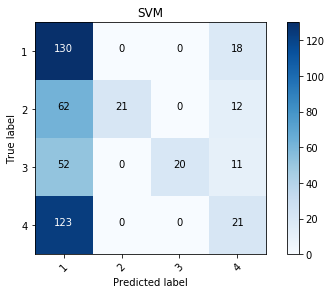

Tree  Confusion matrix, without normalization
[[ 45   0   0 103]
 [  0  19   0  76]
 [  0   0  31  52]
 [  0   0   0 144]]


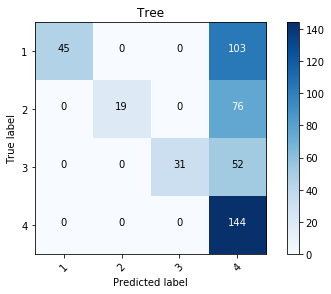

Bayes  Confusion matrix, without normalization
[[74 46  0 28]
 [44 33 10  8]
 [42 31  0 10]
 [65 44  0 35]]


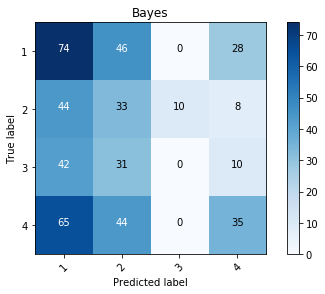

KNN  Confusion matrix, without normalization
[[148   0   0   0]
 [  0  95   0   0]
 [  0   0  83   0]
 [  0   0   0 144]]


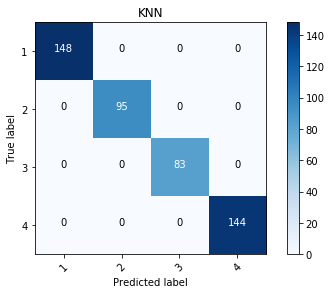

XGB  Confusion matrix, without normalization
[[148   0   0   0]
 [  0  95   0   0]
 [  0   0  83   0]
 [  0   0   0 144]]


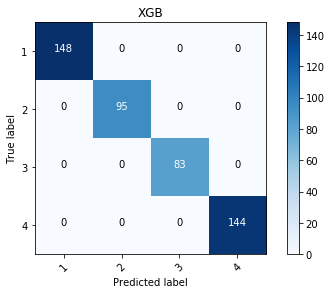

Stacking  Confusion matrix, without normalization
[[148   0   0   0]
 [  0  76  19   0]
 [  0  11  31  41]
 [  0   0   0 144]]


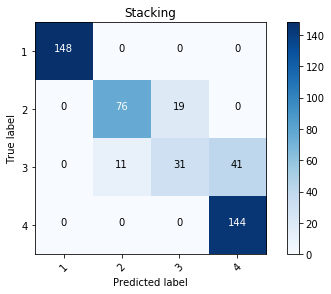

Voting  Confusion matrix, without normalization
[[148   0   0   0]
 [  0  95   0   0]
 [  0   0  83   0]
 [  0   0   0 144]]


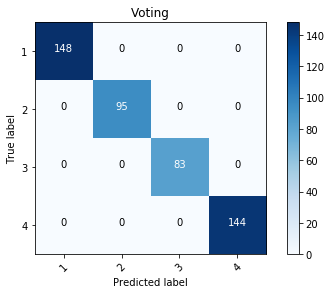

Bagging  Confusion matrix, without normalization
[[148   0   0   0]
 [  0  95   0   0]
 [  0   0  83   0]
 [  0   0   0 144]]


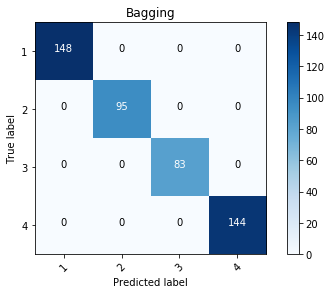

RF  Confusion matrix, without normalization
[[148   0   0   0]
 [  0  95   0   0]
 [  0   0  83   0]
 [  0   0   0 144]]


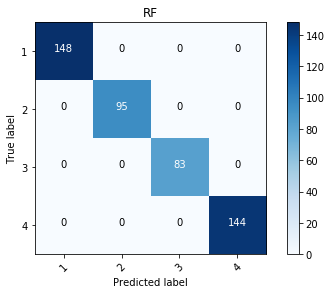

Adaboost  Confusion matrix, without normalization
[[116  17   0  15]
 [ 14  73   0   8]
 [ 22   0  61   0]
 [ 96  15   0  33]]


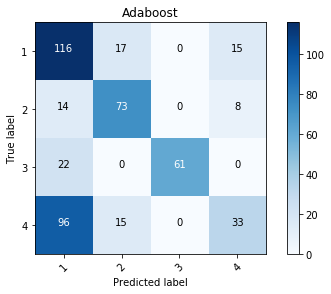

In [18]:
clf.Report(train_X, train_y, [1,2,3,4], show_cm=True)

In [19]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_2D = y.reshape(-1,1)
enc.fit(y_2D)
New_y = enc.transform(y_2D).toarray()

In [20]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation

C:\Users\zxpay\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
from keras.layers.normalization import BatchNormalization
def train(batch_size):
    model = Sequential()
    model.add(Dense(256, input_dim=128, activation='relu', kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(1024, input_dim=256, activation='relu', kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(200, input_dim=512, activation='relu', kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax', kernel_initializer='normal'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X, New_y, epochs=1000, batch_size=batch_size, validation_split=0.2, verbose=0)
    return history

def plot_train_history(history, train_metrics, val_metrics, batch_size):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    plt.title('batch_size=' + str(batch_size))

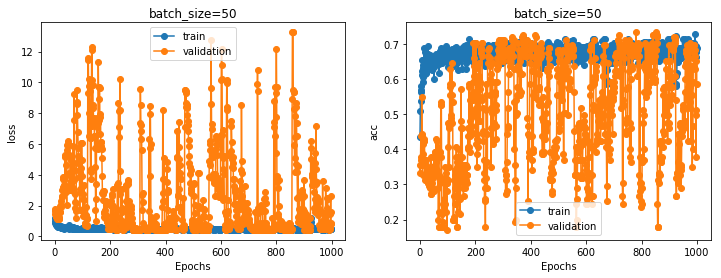

In [22]:
%matplotlib inline
batch_size = 50
history = train(batch_size)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss', batch_size)
plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc', batch_size)

In [23]:
print(history.history.get('acc')[-1])
print(history.history.get('loss')[-1])

0.6871508328830286
0.4456556516541671


In [24]:
print(history.history.get('val_acc')[-1])
print(history.history.get('val_loss')[-1])

0.5851851767963834
0.8533025406025074
